In [16]:
%matplotlib notebook
import random
from copy import deepcopy
import gym
import torch
from collections import namedtuple, defaultdict
import matplotlib.pyplot as pp

seed = 1412343214

# Monte Carlo Methods
This notebook recreates the classic card game Blackjack and trains an agent to play effectively using Monte Carlo Methods.

In [36]:
env = gym.make('Blackjack-v0')
env.seed(seed)  
torch.manual_seed(seed)

In [159]:
State = namedtuple('State', ['hand', 'dealer', 'usable_ace'])
StateAction = namedtuple('StateAction', ['s', 'a'])
StateActionReward = namedtuple('StateActionReward', ['s', 'a', 'r'])
Outcome = namedtuple('Outcome', ['state', 'reward', 'is_over', 'empty'])

class BlackJackPolicy:
    def __init__(self):
        # state: [(action, prob), (action, prob)]
        self.p = defaultdict(lambda: [(True, 0.5), (False, 0.5)])
    def action(self, state, greedy=False):
        if greedy:
            return max(self.p[state], key=lambda x: x[1])[0]
        else:
            actions = [a[0] for a in self.p[state]]
            probabilities = [p[1] for p in self.p[state]]
            return random.choices(actions, probabilities)[0] # Weighted action
    
    def get_policy(self):
        #usable_ace_f.append((state, max(actions, key=lambda x: x[1])[0]))
        policy = {}
        for state, actions in self.p.items():
            policy[state] = max(actions, key=lambda x: x[1])[0]
        return policy
            

def episode(policy):
    env.reset()
    finished = False
    state_action_pairs = []
    while not finished:
        state = State(*env._get_obs())
#         print(state)
        action = policy.action(state)
        outcome = Outcome(*env.step(action))
#         print(action)
#         print(outcome)
        
        state_action_pairs.append(StateActionReward(state, action, outcome.reward))
        finished = outcome.is_over
#     print(state_action_pairs)
#     print("")
    return state_action_pairs

# On Policy First-Visit Monte Carlo Control (for epsilon-soft policies)
Estimates optimal policy by generating episodes from the starting state. 'On Policy' refers to using the same policy to guide actions and generate behavior.

In [173]:
def train(epsilon=0.4, iterations=1000000):
    policy = BlackJackPolicy()
    Q = defaultdict(lambda: defaultdict(lambda: (0, 0)))  # state.action.(sum, count) of post rewards
    
    for i in range(iterations):
        if i % 100000 == 0 and i > 0:
            print(f'Progress: {i} / {iterations}')

        ep_state_actions = episode(policy)                            # generate an episode
        for i,sar in enumerate(ep_state_actions):                     # iterate state-action-rewards in episode
            s = sar.s
            a = sar.a
            returns = sum(map(lambda x: x.r, ep_state_actions[i:]))   # sum of rewards that follows first occurrence
#             print('state, cumulative return')
#             print(f'{s} {a} {returns}')
            Q[s][a] = ((Q[s][a][0] + returns), Q[s][a][1] + 1)        # update Q(s,a) sum of rewards and count
#             print(Q[s][a])
#         print("============================\n")
        for s in map(lambda sar: sar.s, ep_state_actions):
            a_star = max(Q[s], key=lambda a: Q[s][a][0] / Q[s][a][1]) # argmax action based on Q average
            p_a = 1 - epsilon + (epsilon / 2)                         # probability of best action
            p_na = epsilon / 2                                        # probability of all other actions (only 1 other)
            policy.p[s] = [(a_star, p_a), (not a_star, p_na)]         # update policy probability of action based on state
    return policy

In [174]:
optimal_policy = train()

Progress: 100000 / 1000000
Progress: 200000 / 1000000
Progress: 300000 / 1000000
Progress: 400000 / 1000000
Progress: 500000 / 1000000
Progress: 600000 / 1000000
Progress: 700000 / 1000000
Progress: 800000 / 1000000
Progress: 900000 / 1000000


## Disecting the Results
We now have a trained policy with the structure
```
optimal_policy.p = {
  state_0:  # (hand, dealer, usable_ace)
    [ (action, prob), (action, prob) ],
  state_1:
    [ (action, prob), (action, prob) ],
  . . . ,
  state_n:
    [ (action, prob), (action, prob) ]
}
```
Where states `1-n` represent every possible state in our Blackjack environment.
We can group the states together using `usable_ace, dealer` and find the threshold in our `hand` to see when to hit or stick.

In [175]:
def get_hit_threshold(state_actions):
    thresholds = {}
    for usable_ace in [True, False]:
        thresholds[usable_ace] = {}
        for i in range(1, 11):
            
            # Consider all states with usable_ace, dealer=i
            hit_threshold = []
            for state,hit in state_actions.items():
                if state.usable_ace == usable_ace and state.dealer == i:
                    hit_threshold.append((state, hit))

            # Filter on hands where (action) hit=True
            hit_states = list(filter(lambda x: x[1], hit_threshold))
            
            # Get the max hand value
            max_threshold_state = max(hit_states, key=lambda x: x[0].hand)
            
            thresholds[usable_ace][i] = max_threshold_state[0].hand
    return thresholds

hit_thresholds = get_hit_threshold(optimal_policy.get_policy())       

In [176]:
print(hit_thresholds)

{True: {1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17, 8: 17, 9: 17, 10: 17}, False: {1: 16, 2: 11, 3: 11, 4: 11, 5: 11, 6: 11, 7: 14, 8: 14, 9: 14, 10: 14}}


<IPython.core.display.Javascript object>


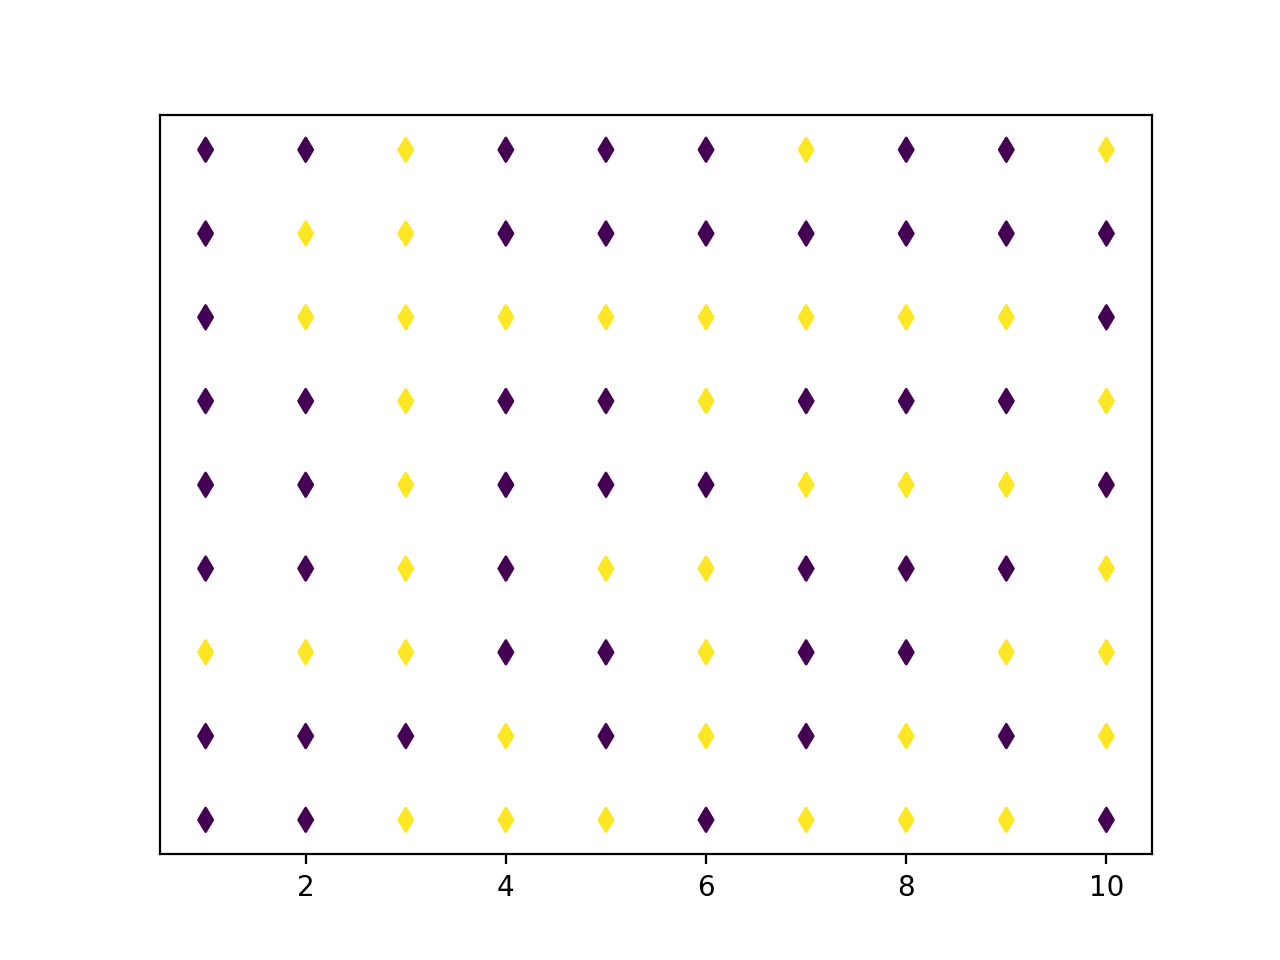

In [46]:
pp.yticks([1.0, 0.0], ['Hit', 'Stay'])
pp.scatter(x=usable_ace_tx, y=usable_ace_ty, c=usable_ace_th, marker='d')


In [ ]:
def off_policy_prediction(o_policy):
    b_policy = BlackJackPolicy(greedy=False)
    Q = defaultdict(lambda: defaultdict(lambda: (0, 0)))  # state.action.(sum, count) of post rewards
    
    for i in range(10000):
        ep_state_actions = episode(b_policy)
    